## Dependencies

In [759]:
import networkx as nx
import matplotlib.pyplot as plt
import ast
import os
import textwrap
from tabulate import tabulate
from termcolor import colored
import re
import gc
import json
from collections import defaultdict

## Classes Definitions

In [760]:
class DDG_Node:
    def __init__(self, line_number,statement):
        self.statement = statement
        self.line_number = line_number
        self.has=[]
        self.needs=[]

In [761]:
class DDG_Edge:
    def __init__(self, src, dest,dependencies):
        self.src = src
        self.dest = dest
        self.dependencies = dependencies

In [762]:
class Debugger:
    def __init__(self):
        pass
    def print_unparsed_function(self, function):
        print("\n" + "="*40)
        print(f"Function Extracted: {function.name}")
        print("="*40)
        print(textwrap.indent(ast.unparse(function), "    "))  # Indent for readability
        print("="*40)
        print(f"Function Completed: {function.name}")
        print("="*40)
    def print_entry_point(self, entry_point):
        print("\n" + "="*40)
        print(f"Entry Point Extracted")
        print("="*40)
        print(textwrap.indent(entry_point, "    "))
        print("="*40)
        print(f"Entry Point Completed")
        print("="*40)
    def print_DDG_node(self, node):
        print("\n" + "="*40)
        print(f"Line Number: {node.line_number}")
        print("\n" + "="*40)
        print(f"Has: {node.has}")
        print("\n" + "="*40)
        print(f"Needs: {node.needs}")
        print("\n" + "="*40)
    def print_DDG_edge(self, edge):
        print("\n" + "="*40)
        print("\n")
        print(f"Source: {edge.src}")
        print(f"Destination: {edge.dest}")
        print(f"Dependencies: {edge.dependencies}")
        print("\n" + "="*40)


In [763]:
class _Parser:
    def __init__(self,tree):
        self.tree=tree
        self.entry_point = None
        self.functions = []
        self.debugger=Debugger()
    #! extract functiona and entry point
    def extract_snippets(self,debug=False):
       for node in self.tree.body:
        #! Get function source code, name and arguements and put them in a tuple
        if isinstance(node, ast.FunctionDef):
            func_name = node.name
            arguements = [arg.arg for arg in node.args.args]
            func_code = ast.unparse(node)  
            pattern = rf'def\s+{func_name}\s*\(.*?\):\s*\n'
            func_code = re.sub(pattern, '', func_code)
            func_code = textwrap.dedent(func_code)
            self.functions.append((func_name,arguements,func_code))
            if debug:
                self.debugger.print_unparsed_function(node)
        elif isinstance(node, ast.If):
            self.entry_point = ast.unparse(node)
            self.entry_point = self.entry_point.replace("if __name__ == '__main__':", "")
            self.entry_point=textwrap.dedent(self.entry_point)
            print(f"Entry Point: {self.entry_point}")
            if debug:
                self.debugger.print_entry_point(self.entry_point)

In [764]:
class DDG:
    def __init__(self):
        self.debugger=Debugger()
        self.edges=[]
        self.nodes=[]      
    #? TODO Handle Loops
    def extract_dependencies(self,snippet,functions,function=False,debug=False):
        #! handle the function tuple
        if function:
            func_name=snippet[0]
            arguements=snippet[1]
            snippet=snippet[2]
            #! add the function definition as a node
            node = DDG_Node(0,'def '+func_name+'('+','.join(arguements)+'):')
            node.has.extend(arguements)
            self.nodes.append(node)
            
        sub_tree=ast.parse(snippet)
        def visit_has_needs(self, node,number):
            print(ast.dump(node, indent=4))
            #! create a new node
            gnode = DDG_Node(number,ast.unparse(node))
            #! get variables being assigned to
            if isinstance(node, ast.Assign):  
                for target in node.targets:
                    if isinstance(target, ast.Name):
                        gnode.has.append(target.id)
            #! handle in place operations
            if isinstance(node, ast.Expr):
                list_funcs = ['pop', 'append', 'sort', 'extend', 'reverse', 'insert', 'remove', 'clear']
                
                call = node.value
                if isinstance(call, ast.Call) and isinstance(call.func, ast.Attribute):
                    func_name = call.func.attr  # e.g., 'extend'
                    if func_name in list_funcs:
                        target = call.func.value
                        if isinstance(target, ast.Name):
                            var_name = target.id  # 'y'
                            gnode.has.append(var_name)


            #! handle if conditions
            if isinstance(node, ast.If):
                temp = set()
                for subnode in ast.walk(node):
                    if isinstance(subnode, ast.Assign):
                        for target in subnode.targets:
                            if isinstance(target, ast.Name):
                                temp.add(target.id)
                    #! handle in place operations
                    elif isinstance(subnode, ast.Expr):
                        list_funcs = ['pop', 'append', 'sort', 'extend', 'reverse', 'insert', 'remove', 'clear']
                        
                        call = subnode.value
                        if isinstance(call, ast.Call) and isinstance(call.func, ast.Attribute):
                            func_name = call.func.attr  # e.g., 'extend'
                            if func_name in list_funcs:
                                target = call.func.value
                                if isinstance(target, ast.Name):
                                    var_name = target.id  # 'y'
                                    gnode.has.append(var_name)
                            
                gnode.has.extend(temp)
                del temp
                gc.collect()
            #! handle the function return statement
            elif isinstance(node, ast.Return):
                if isinstance(node.value, ast.Name):
                    gnode.needs.append(node.value.id)
            #! Get variables used in the assignment
            used_vars = {name.id for name in ast.walk(node) if isinstance(name, ast.Name) and isinstance(name.ctx, ast.Load)}
            func_names = [name for name, _, _ in functions]
            used_vars = used_vars - set(func_names)  # Exclude function names from used_vars
            gnode.needs.extend(used_vars)
            self.nodes.append(gnode)
            if debug:
                self.debugger.print_DDG_node(gnode)
        for i,node in enumerate(sub_tree.body):
            visit_has_needs(self,node,i+1)
            
    def construct_edges(self,debug=False):
        if not self.nodes:
            raise ValueError("No nodes to construct edges from. Please run 'extract_dependencies' first.")
        #! a dictionary to hold the last occurence OF dependencies
        deps={}
        for node in self.nodes:
            edges_to_construct={}
            for need in node.needs:
                if need in deps:
                    if (deps[need],node.line_number) not in edges_to_construct:
                        edges_to_construct[(deps[need],node.line_number)]=[]
                    edges_to_construct[(deps[need],node.line_number)].append(need)
            for edge in edges_to_construct:
                edge=DDG_Edge(edge[0],edge[1],edges_to_construct[edge])
                self.edges.append(edge)    
                if debug:
                    self.debugger.print_DDG_edge(edge)
            for has in node.has:
                deps[has]=node.line_number
    def visualize_graph(self):
        if not self.nodes:
            raise ValueError("No nodes or edges to visualize. Please run 'extract_dependencies' and 'construct_edges' first.")
        G = nx.DiGraph()
        for node in self.nodes:
            G.add_node(node.line_number)

        edge_labels = {}
        for edge in self.edges:
            G.add_edge(edge.src, edge.dest)
            edge_labels[(edge.src, edge.dest)] = ", ".join(map(str, edge.dependencies)) 

        pos = nx.spring_layout(G, k=5)  #! Adjust k to control spacing

        nx.draw(
            G, pos, with_labels=True, 
            node_size=2000, node_color='darkblue', 
            font_color='white', font_weight='bold', font_size=12
        )

        nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)
        plt.show()
  

    def visualize_graph_data(self):
        if not self.nodes:
            raise ValueError("No nodes or edges to visualize. Please run 'extract_dependencies' and 'construct_edges' first.")
        node_data = [{'code line': node.line_number,'statement':node.statement, 'has': node.has, 'needs': node.needs} for node in self.nodes]
        edge_data = [{'Node': edge.dest, 'Depends on': edge.src,  'Dependency': edge.dependencies} for edge in self.edges]

        node_table = tabulate(node_data, headers="keys", tablefmt="fancy_grid")
        edge_table = tabulate(edge_data, headers="keys", tablefmt="fancy_grid")

        print(colored("Nodes Table:", "cyan", attrs=["bold"]))
        print(node_table)
        print("\n" + colored("Edges Table:", "yellow", attrs=["bold"]))
        print(edge_table)
    def save_to_json(self):
        if not self.nodes:
            raise ValueError("No nodes or edges to save. Please run 'extract_dependencies' and 'construct_edges' first.")
        node_data = [{'code line': node.line_number,'statement':node.statement, 'has': node.has, 'needs': node.needs} for node in self.nodes]
        edge_dict = defaultdict(lambda: {"Node": None, "Depends on": []})
        for edge in self.edges:
            if edge.dest not in edge_dict:
                edge_dict[edge.dest]["Node"] = edge.dest
            edge_dict[edge.dest]["Depends on"].append({
                "Node": edge.src,
                "Dependency": edge.dependencies
            })
        json1 = json.dumps(node_data, indent=4)
        json2 = json.dumps(edge_dict, indent=4)
        return json1,json2

        

In [765]:
class DDG_Wrapper:
    def __init__(self,tree):
        self.parser=_Parser(tree)
        self.parser.extract_snippets()
        #! index 0 is always the entry point else functions
        self.ddgs=[]
    def build_ddgs(self):
        if not self.parser.functions and not self.parser.entry_point:
            raise ValueError("No functions or entry points to extract dependencies from. Please run 'extract_snippets' first.")
        if self.parser.entry_point:
            ddg=DDG()
            ddg.extract_dependencies(self.parser.entry_point,self.parser.functions)
            ddg.construct_edges()
            self.ddgs.append(ddg)
        for function in self.parser.functions:
            ddg=DDG()
            ddg.extract_dependencies(function,self.parser.functions,function=True)
            ddg.construct_edges()
            self.ddgs.append(ddg)
            
    #! Visualize the graph (index=-1 for all graphs)
    def visualize_graph(self,index=-1):
        if index == -1:
            for index in range(len(self.ddgs)):
                self.ddgs[index].visualize_graph()
        else:
            self.ddgs[index].visualize_graph()
    #! Visualize the graph data (index=-1 for all graphs)
    def visualize_graph_data(self,index=-1):
        if index == -1:
            for index in range(len(self.ddgs)):
                print(f"Graph {index+1}")
                self.ddgs[index].visualize_graph_data()
                print('-'*40)
                print('\n')
        else:        
            print(f"Graph {index+1}")
            self.ddgs[index].visualize_graph_data()
            print('\n')
    def save_to_json(self,folder_name):
        for index,ddg in enumerate(self.ddgs):
            node_data,edge_data=ddg.save_to_json()
            with open(f"{folder_name}/graph_{index}_nodes.json", "w") as outfile:
                outfile.write(node_data)
            with open(f"{folder_name}/graph_{index}_edges.json", "w") as outfile:
                outfile.write(edge_data)

## GLobal Variables for testing

In [766]:
testcases_folder_path="testcases"
testcase=os.path.join(testcases_folder_path, "t1_basic_main_parsing.py")

## Implementation Testing

In [767]:
with open(testcase, 'r') as f:
    code = f.read()

# Remove all content between any two "#---------------------------------------------------------------------------------------------------------"
code = re.sub(
    r"#-+\n.*?\n#-+\n",
    "",
    code,
    flags=re.DOTALL
)

tree = ast.parse(code)

In [768]:
print(ast.dump(tree, indent=4))

Module(
    body=[
        FunctionDef(
            name='func1',
            args=arguments(
                posonlyargs=[],
                args=[
                    arg(arg='x')],
                kwonlyargs=[],
                kw_defaults=[],
                defaults=[]),
            body=[
                Return(
                    value=BinOp(
                        left=Name(id='x', ctx=Load()),
                        op=Add(),
                        right=Constant(value=1)))],
            decorator_list=[]),
        FunctionDef(
            name='func2',
            args=arguments(
                posonlyargs=[],
                args=[
                    arg(arg='x')],
                kwonlyargs=[],
                kw_defaults=[],
                defaults=[]),
            body=[
                Pass()],
            decorator_list=[]),
        If(
            test=Compare(
                left=Name(id='__name__', ctx=Load()),
                ops=[
                    Eq()],

In [769]:
graph=DDG_Wrapper(tree)

Entry Point: 
x = 5
y = x + 3
z = x * y
x = x + 2
y = x
if z > x:
    z = 9
elif z < y:
    l.append(7)
else:
    z = 8
l = func1(x)
func2(l)


In [770]:
graph.build_ddgs()

Assign(
    targets=[
        Name(id='x', ctx=Store())],
    value=Constant(value=5))
Assign(
    targets=[
        Name(id='y', ctx=Store())],
    value=BinOp(
        left=Name(id='x', ctx=Load()),
        op=Add(),
        right=Constant(value=3)))
Assign(
    targets=[
        Name(id='z', ctx=Store())],
    value=BinOp(
        left=Name(id='x', ctx=Load()),
        op=Mult(),
        right=Name(id='y', ctx=Load())))
Assign(
    targets=[
        Name(id='x', ctx=Store())],
    value=BinOp(
        left=Name(id='x', ctx=Load()),
        op=Add(),
        right=Constant(value=2)))
Assign(
    targets=[
        Name(id='y', ctx=Store())],
    value=Name(id='x', ctx=Load()))
If(
    test=Compare(
        left=Name(id='z', ctx=Load()),
        ops=[
            Gt()],
        comparators=[
            Name(id='x', ctx=Load())]),
    body=[
        Assign(
            targets=[
                Name(id='z', ctx=Store())],
            value=Constant(value=9))],
    orelse=[
        If(


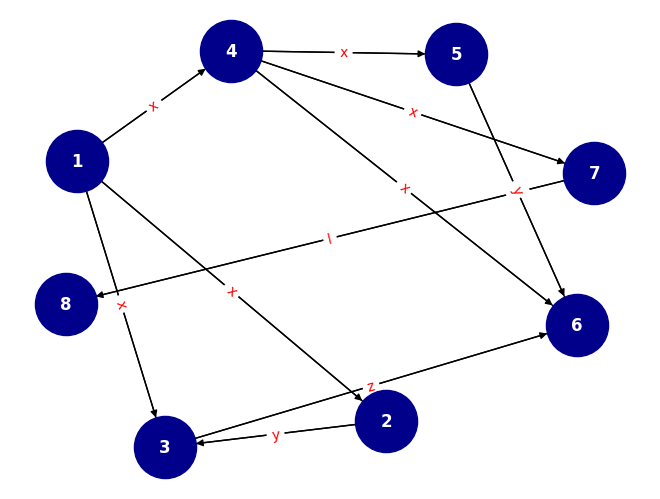

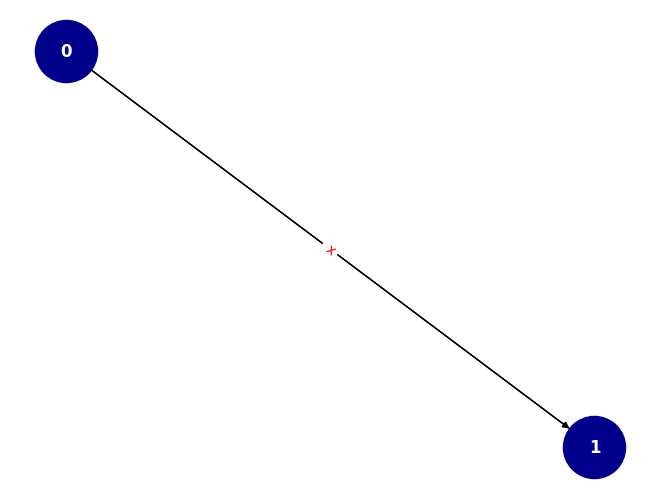

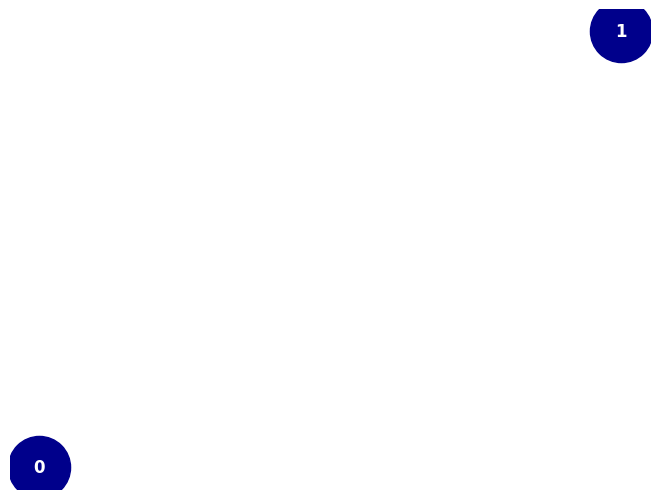

In [771]:
graph.visualize_graph()

In [772]:
graph.visualize_graph_data()

Graph 1
Nodes Table:
╒═════════════╤═════════════════╤════════════╤══════════════════════╕
│   code line │ statement       │ has        │ needs                │
╞═════════════╪═════════════════╪════════════╪══════════════════════╡
│           1 │ x = 5           │ ['x']      │ []                   │
├─────────────┼─────────────────┼────────────┼──────────────────────┤
│           2 │ y = x + 3       │ ['y']      │ ['x']                │
├─────────────┼─────────────────┼────────────┼──────────────────────┤
│           3 │ z = x * y       │ ['z']      │ ['x', 'y']           │
├─────────────┼─────────────────┼────────────┼──────────────────────┤
│           4 │ x = x + 2       │ ['x']      │ ['x']                │
├─────────────┼─────────────────┼────────────┼──────────────────────┤
│           5 │ y = x           │ ['y']      │ ['x']                │
├─────────────┼─────────────────┼────────────┼──────────────────────┤
│           6 │ if z > x:       │ ['l', 'z'] │ ['x', 'z', 'y', 'l'] │

In [773]:
filename = f"outputs/{testcase}"
filename = os.path.splitext(filename)[0]  # Remove .py extension

if not os.path.exists(filename):
    os.makedirs(filename)
graph.save_to_json(filename)